In [1]:
import sys
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python/")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/")
sys.path.append("/home/rossidaniel/Dropbox")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python")

In [2]:
import Bin_Packing_Py as BP
import BP_print
import BP_plot
import BP_utilities
import HA_routines
import BP_instances

import matplotlib
%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = [6,3.5]

from ortools.linear_solver import pywraplp
import random
import time
import csv

import pandas as pd
from mail import send_mail
from Test_BP_G import euristic

In [13]:
def correctSequence(solution):
    items =solution.getAnchors(0)
    for i in items:
        l,r,h = [0,0,0]
        for j in items:
            if (i.item.order_id < j.item.order_id and i != j):

                a_r = i.realDim()
                b_r = j.realDim()

                a_p = i.pos
                b_p = j.pos    
                
                #il pacco i è al di sotto dell'oggetto j
                if BP.Anchor.ProjectionCommonArea(i,j,BP.Direction.z) == True:
                    if round(a_p.z,6) + round(a_r.height,6) <= round(b_p.z,6): l=1;r=1;h=1
                #il pacco i è davanti o dietro il pacco j
                if BP.Anchor.ProjectionCommonArea(i,j,BP.Direction.y) == True:
                    if round(a_p.y,6) + round(a_r.depth,6) <= round(b_p.y,6): h+=1
                #il pacco i è a sinistra o a destra del pacco j
                if BP.Anchor.ProjectionCommonArea(i,j,BP.Direction.x) == True:
                    if round(b_p.x,6) + round(b_r.width,6) <= round(a_p.x,6): l+=1 
                    else: r +=1
            #print l,r,h
            if l*r*h > 0: return 0
    return 1

In [4]:
class istanza:
    def __init__(self,int1,int2,ist_id):
        self.index=ist_id
        self.width=int1
        self.depth=int2

class intervallo:
    def __init__(self,a,b):
        self.a=a
        self.b=b

In [5]:
def tc_sfida(ist):
    item_list = []
    bin_list = []

    bin_list.append(BP.Bin(2.70, 50, 2.45))
    bin_list.append(BP.Bin(0, 0, 0))

    n_items =random.randint(3,5)

    for i in range(n_items):
        w=random.uniform(ist.width.a,ist.width.b)
        d=random.uniform(ist.depth.a,ist.depth.b)
        h=random.uniform(0.5,1.5)
        item = BP.Item(i,h,d,w)
        item.stackable = random.randint(0,0)
        item.order_id = random.randint(0,3)
        item.weight = 4
        item_list.append(item)

    return item_list, bin_list

In [6]:
class model_bin_packing:
    def __init__(self,item_list,bin_list):
        self.bp = BP.BinPack()
        self.bp.items.extend(item_list)
        self.bp.bins.extend(bin_list)
        
    def buildModel(self,amount_time=300000):
        solver = pywraplp.Solver('Model2DR', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        #importo dimensioni dei pacchi e del camion
        n=len(self.bp.items)

        w =[self.bp.items[i].width for i in range(n)]
        d =[self.bp.items[i].depth for i in range(n)]
        h =[self.bp.items[i].height for i in range(n)]
        M=sum([max(w[i],d[i]) for i in range(n)])

        W =self.bp.bins[0].width
        D =solver.NumVar(0,M,"D")
        H =self.bp.bins[0].height
        
        Mw=W+M
        Md=self.bp.bins[0].depth+M
        Mz=H+max(h)
                
        # definisco le variabili
        l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        r =[solver.BoolVar("r%d" % (i)) for i in range(n)]

        x =[solver.NumVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
        y =[solver.NumVar(0,solver.infinity(),"y%d" % i) for i in range(n)]


        #definisco i constraints
        for i in range(n):
            for j in range(n):
                if(i < j):
                    solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] >= 1)                           #(1)
                if(i != j):
                    solver.Add(x[i] - x[j] + Mw * l[i][j] <= Mw - w[i]*(1-r[i]) - d[i]*r[i])         #(2)
                    solver.Add(y[i] - y[j] + Md * b[i][j] <= Md - d[i]*(1-r[i]) - w[i]*r[i])         #(3)
            solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)                                        #(4)
            solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)                                        #(5)

        #funzione obiettivo
        objective = solver.Objective()
        objective.SetCoefficient(D,1)
        objective.SetMinimization()

        #soluzione
        solver.SetTimeLimit(amount_time)
        t=time.time()
        solver.Solve()
        t =time.time()-t

        s = BP.Solution(self.bp)
        for i in range(len(self.bp.items)):
            rt = False if r[i].solution_value() == 0 else True
            s.pushItem(self.bp.items[i],0,BP.Point(round(x[i].solution_value(),3),round(y[i].solution_value(),3),0),rt,False)
        return s,t,w,d,h,n
    
    def BuildSolution(self,s):
        print s
    
    def plotSolution(self,s):
        BP_plot.plotSolution(s)
    
    def plot3Dsolution(self,s):
        BP_plot.plot3DSolution(s,0)

    def feasible(self):
        return self.bp.bins[0].height*self.bp.bins[0].width >= sum([self.bp.items[i].width*self.bp.items[i].height for i in range(len(self.bp.items))])

In [7]:
def tc_sfida():
    item_list = []
    bin_list = []

    bin_list.append(BP.Bin(2.70, 13.5, 2.45))
    bin_list.append(BP.Bin(0, 0, 0))

    n_items =random.randint(3,6)

    for i in range(n_items):
        w=random.uniform(0.5,2.45)
        d=random.uniform(0.5,1)
        h=random.uniform(0.5,1.5)
        item = BP.Item(i,h,d,w)
        item.stackable = random.randint(0,0)
        item.order_id = random.randint(1,5)
        item.weight = 4
        item_list.append(item)

    return item_list, bin_list

In [8]:
ist = []
df = pd.read_excel('istanza.xlsx')
for i in range(len(df)):
    ist.append(istanza(intervallo(df.w_a[i],df.w_b[i]),intervallo(df.d_a[i],df.d_b[i]),i))

In [9]:
tot_df = pd.DataFrame({'n_items': [], 'Eu_obj': [],'Mod_obj': [], 'Time': []})
tot_df = tot_df[['n_items', 'Eu_obj', 'Mod_obj', 'Time']]

In [10]:
n_items = []
Time = []
eu_obj = []
mod_obj = []
feasible = []

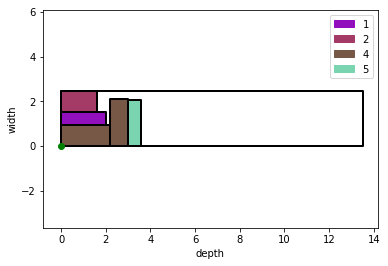

In [12]:
i = 0
while True:
    i +=1
    items,bins=tc_sfida()
    model = model_bin_packing(items,bins)
    s,t,w,d,h,n=model.buildModel()
    s.computeObj()
    mod_obj.append(s.obj)
    eu_obj.append(euristic(items,bins))
    Time.append(round(t,3))
    n_items.append(n)
    feasible.append(checkSquence(s))
    if checkSquence(s) == 0:
        BP_plot.plotSolution(s)
        break
    if i >= 100: break

In [68]:
#send_mail()

In [49]:
#tot_df

In [98]:
correctSequenceUnload(s)

0

In [26]:
print s


BIN: (w,d,h) = (2.45,13.5,2.7)
[Anchors]:
Point: (x,y,z) = (1.909,0.0,0.0), Item: [0 (3)] (w,d,h) = (2.13091639112,0.541076518437,0.856139135365), weight = 4.0 [R] 
Point: (x,y,z) = (1.143,0.788,0.0), Item: [1 (1)] (w,d,h) = (1.36515060609,0.6961965257,0.983991937766), weight = 4.0 [R] 
Point: (x,y,z) = (0.0,1.388,0.0), Item: [2 (2)] (w,d,h) = (1.14334713025,0.582963272312,0.80407740921), weight = 4.0
Point: (x,y,z) = (0.0,0.0,0.0), Item: [3 (3)] (w,d,h) = (1.90341530412,0.787874536581,0.806069562529), weight = 4.0
Point: (x,y,z) = (0.0,0.788,0.0), Item: [4 (5)] (w,d,h) = (0.99592613803,0.599835127057,0.939987383253), weight = 4.0
-----------
[Extreme Points]:
(x,y,z) = (0.0,0.0,0.0)
-----------

BIN: (w,d,h) = (0.0,0.0,0.0)
[Anchors]:

-----------
[Extreme Points]:
(x,y,z) = (0.0,0.0,0.0)
-----------

Feasibility: True 
Obj: 2.15315060609


<IPython.core.display.Javascript object>


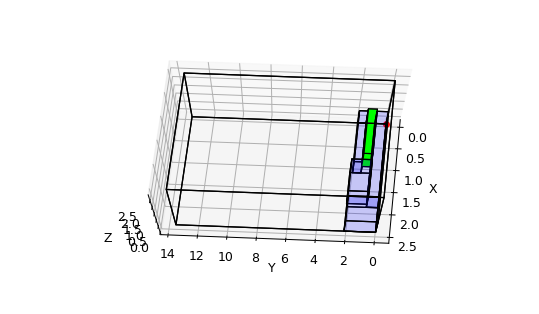

In [71]:
BP_plot.plot3DSolution(s,0,4)